# Predict Future Sales

### Goal of this datascience project: Predict total sales for every product and store in the next month.

The goal is to predict the number of sales of each store and item in the month of November 2015.

#### 1) Read Data:

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.linear_model import LinearRegression

In [32]:
item_categories_df = pd.read_csv('item_categories.csv')
items_df = pd.read_csv('items.csv')
sales_train_df = pd.read_csv('sales_train.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')
shops_df = pd.read_csv('shops.csv')
test_df = pd.read_csv('test.csv')

In [33]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [34]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [35]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [36]:
sample_submission_df.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [37]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [38]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


First we drop all negative values in the column item_cnt_day. This data field represents the number of sales of an specific product on a given day, negative values can represent the number of returns of that product to the store. Since we are predicting the sales in the next month in a first analysis we can ignore these values.

In [39]:
sales_train_df2 = sales_train_df.drop(sales_train_df[sales_train_df['item_cnt_day'] < 0].index)
sales_train_df2.reset_index(drop = True, inplace = True)
sales_train_df2

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,06.01.2013,0,25,2554,1709.05,1.0
3,15.01.2013,0,25,2555,1099.00,1.0
4,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2928488,10.10.2015,33,25,7409,299.00,1.0
2928489,09.10.2015,33,25,7460,299.00,1.0
2928490,14.10.2015,33,25,7459,349.00,1.0
2928491,22.10.2015,33,25,7440,299.00,1.0


We are interested only on the number of sales of each product in each store by month, so we can stick with the columns: date_block_num, shop_id, item_id and item_cnt_day.

In [40]:
items_sales = sales_train_df2.groupby(['item_id','date_block_num'])['item_cnt_day'].sum()
items_sales_df = pd.DataFrame({'item_cnt_month':items_sales}).reset_index() # Create dataframe
items_sales_df

,item_id,date_block_num,item_cnt_month
0,0,20,1.0
1,1,15,2.0
2,1,18,1.0
3,1,19,1.0
4,1,20,1.0
...,...,...,...
233797,22168,0,2.0
233798,22168,1,2.0
233799,22168,2,1.0
233800,22168,8,1.0


In [41]:
np.sort(items_sales_df['date_block_num'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

#### Create a time series of the sales of each item idependent of the store it was sold.

In [42]:
months = np.sort(items_sales_df['date_block_num'].unique())
cols = items_sales_df['item_id'].unique()
values = np.zeros((len(months),len(cols)))

items_series = pd.DataFrame(values, columns = cols)
print(items_series.shape)
items_series.head()

(34, 21804)


,0,1,2,3,4,5,6,7,8,9,...,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
for index, row in items_sales_df.iterrows():
    # Iterate over the rows
    month_val = row['date_block_num'] 
    item_val = row['item_id']
    items_series.at[month_val,item_val] = row['item_cnt_month'] # save the number of items sold in that month
items_series.head()

,0,1,2,3,4,5,6,7,8,9,...,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
items_complete_series = items_series[items_series > 0].dropna(axis= 'columns') # pick items with sales in the 34 months
items_complete_series.head()

,32,33,45,49,51,53,57,308,325,448,...,21914,21928,21929,21980,22087,22088,22091,22092,22111,22139
0,299.0,61.0,8.0,5.0,13.0,8.0,1.0,3.0,4.0,4.0,...,8.0,11.0,3.0,7.0,222.0,380.0,67.0,221.0,5.0,28.0
1,208.0,40.0,7.0,9.0,18.0,6.0,5.0,5.0,4.0,6.0,...,4.0,4.0,5.0,8.0,164.0,233.0,42.0,127.0,5.0,28.0
2,178.0,32.0,7.0,13.0,23.0,7.0,1.0,6.0,3.0,6.0,...,7.0,7.0,6.0,6.0,228.0,286.0,50.0,111.0,7.0,24.0
3,97.0,16.0,6.0,12.0,11.0,5.0,8.0,6.0,1.0,5.0,...,6.0,2.0,5.0,3.0,174.0,203.0,56.0,89.0,4.0,18.0
4,66.0,12.0,4.0,8.0,14.0,7.0,8.0,6.0,2.0,5.0,...,2.0,5.0,7.0,5.0,181.0,196.0,61.0,87.0,5.0,11.0


#### Let's visualize the time series of some products and use the sliding window method to visualize the correlation between time steps in each time series

In [45]:
random.seed(345)
random_items = np.array(random.sample(items_complete_series.columns.values.tolist(), 35)) # pick random items
random_items_series = items_complete_series[random_items]

In [46]:
months = items_complete_series.index.values

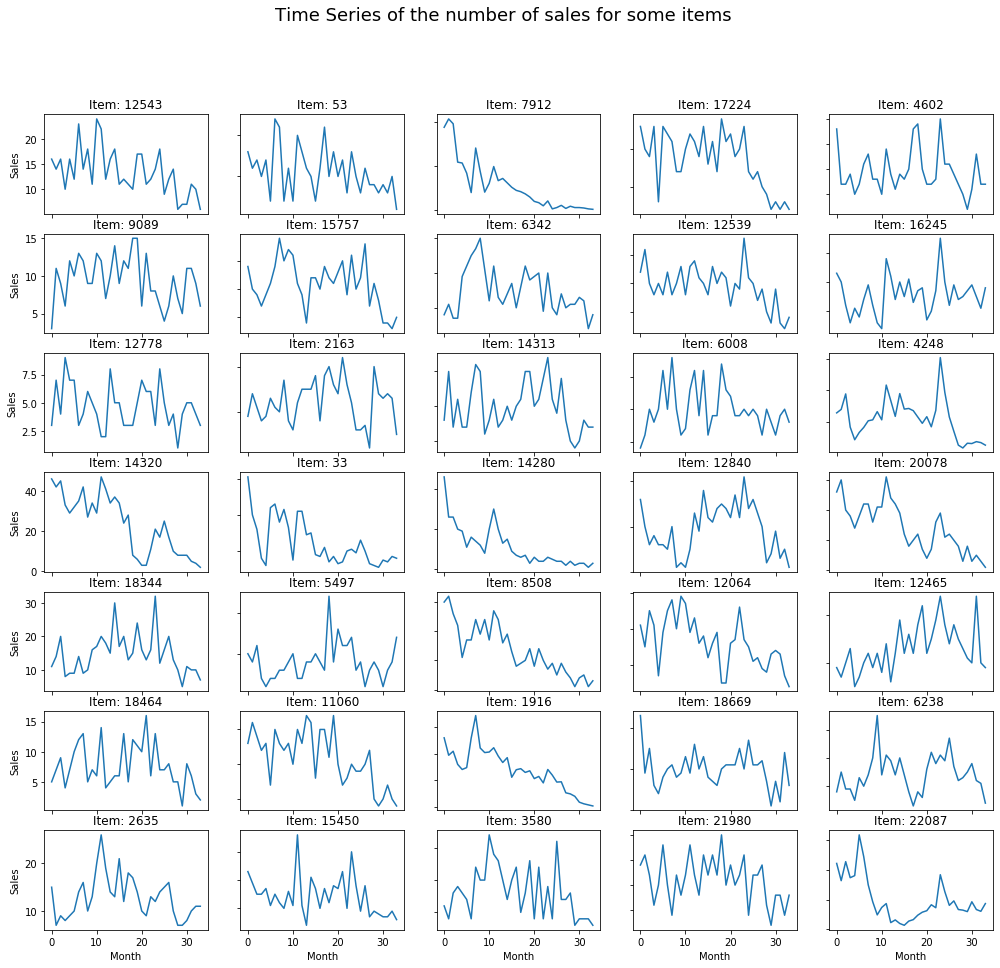

In [47]:
fig,ax = plt.subplots(7,5,figsize=(17,15))
k = 0
fig.suptitle('Time Series of the number of sales for some items',fontsize = 18) # general title
for i in range(7):
    for j in range(5):
        sales = random_items_series[random_items[k]]
        ax[i,j].plot(months, sales)
        ax[i,j].set_title(f'Item: {random_items[k]}',fontsize=12)
        k+=1
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Month',fontsize = 10)
    axx.set_ylabel('Sales',fontsize = 10)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

In [48]:
random_rolled_series = np.roll(random_items_series,-1,axis=0)
random_rolled_series

array([[ 14.,   6., 206., ...,   4.,   8., 164.],
       [ 16.,   7., 195., ...,   8.,   6., 228.],
       [ 10.,   5., 108., ...,   9.,   3., 174.],
       ...,
       [ 10.,   5.,   2., ...,   4.,   2.,  61.],
       [  6.,   1.,   1., ...,   3.,   4.,  87.],
       [ 16.,   8., 187., ...,   6.,   7., 222.]])

Use the sliding window or lag method with window size of 1. This is used to see the correlation of sales between each month

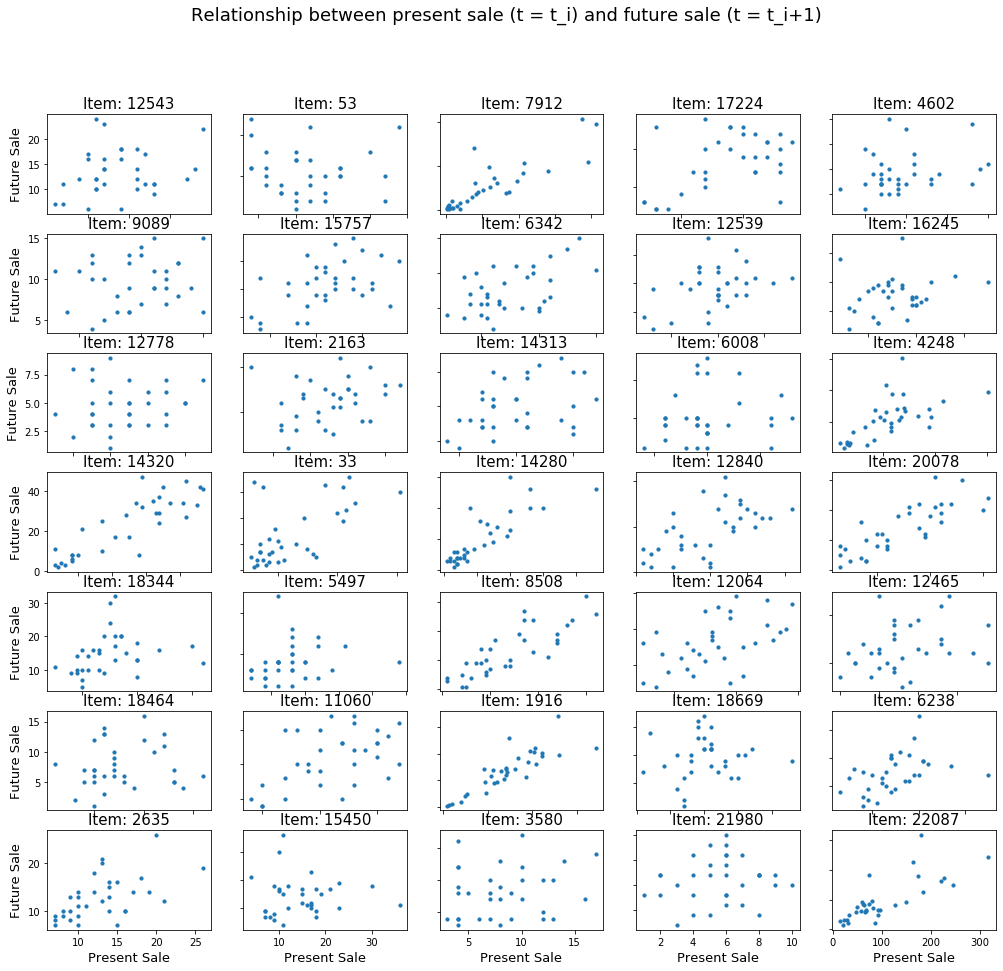

In [49]:
fig,ax = plt.subplots(7,5,figsize=(17,15))
k = 0
fig.suptitle('Relationship between present sale (t = t_i) and future sale (t = t_i+1)',fontsize = 18)

for i in range(7):
    for j in range(5):
        sales_present = random_items_series[random_items[k]][:-1]
        sales_future = random_rolled_series[:-1,k]
        ax[i,j].scatter(sales_present, sales_future, s = 10)
        ax[i,j].set_title(f'Item: {random_items[k]}',fontsize=15)
        k+=1
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Present Sale',fontsize = 13)
    axx.set_ylabel('Future Sale',fontsize = 13)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

Print the correlations between each sales times series and the next sale time series of all the data series

In [50]:
rolled_complete_series = np.roll(items_complete_series,-1, axis=0)
rolled_complete_series

array([[208.,  40.,   7., ..., 127.,   5.,  28.],
       [178.,  32.,   7., ..., 111.,   7.,  24.],
       [ 97.,  16.,   6., ...,  89.,   4.,  18.],
       ...,
       [ 19.,  17.,   6., ...,  44.,   1.,   5.],
       [ 22.,  16.,   1., ...,  46.,   1.,   9.],
       [299.,  61.,   8., ..., 221.,   5.,  28.]])

In [51]:
complete_items_corr = []
for i in range(items_complete_series.columns.shape[0]):
    corr_matrix = np.corrcoef(items_complete_series[items_complete_series.columns[i]][:-1],rolled_complete_series[:-1,i])
    corr_coef = corr_matrix[0][1]
    complete_items_corr.append(corr_coef)
complete_items_corr = np.array(complete_items_corr)

Items with high correlation between time steps:

In [52]:
high_corr = complete_items_corr[abs(complete_items_corr) > 0.85]
high_corr

array([0.94232025, 0.93848205, 0.85267863, 0.85330174, 0.85050773,
       0.86349833, 0.91074602, 0.88885921, 0.89626321, 0.98669479,
       0.85871749, 0.85302802, 0.93243979, 0.884154  , 0.96078547,
       0.95432014, 0.86641098, 0.86565191, 0.85883685, 0.97294267,
       0.86264579, 0.88735876, 0.95995945, 0.91544164])

In [53]:
items_high_corr = items_complete_series.columns[abs(complete_items_corr) > 0.85]
items_high_corr

Int64Index([   32,  1249,  1830,  1916,  2416,  3007,  4251,  5811,  6045,
             6953,  7912,  8497,  9033, 10051, 11065, 11184, 12286, 12839,
            13511, 13901, 14320, 15833, 16450, 17717],
           dtype='int64')

In [54]:
random_rolled_series2 = np.roll(items_complete_series[items_high_corr],-1,axis=0)

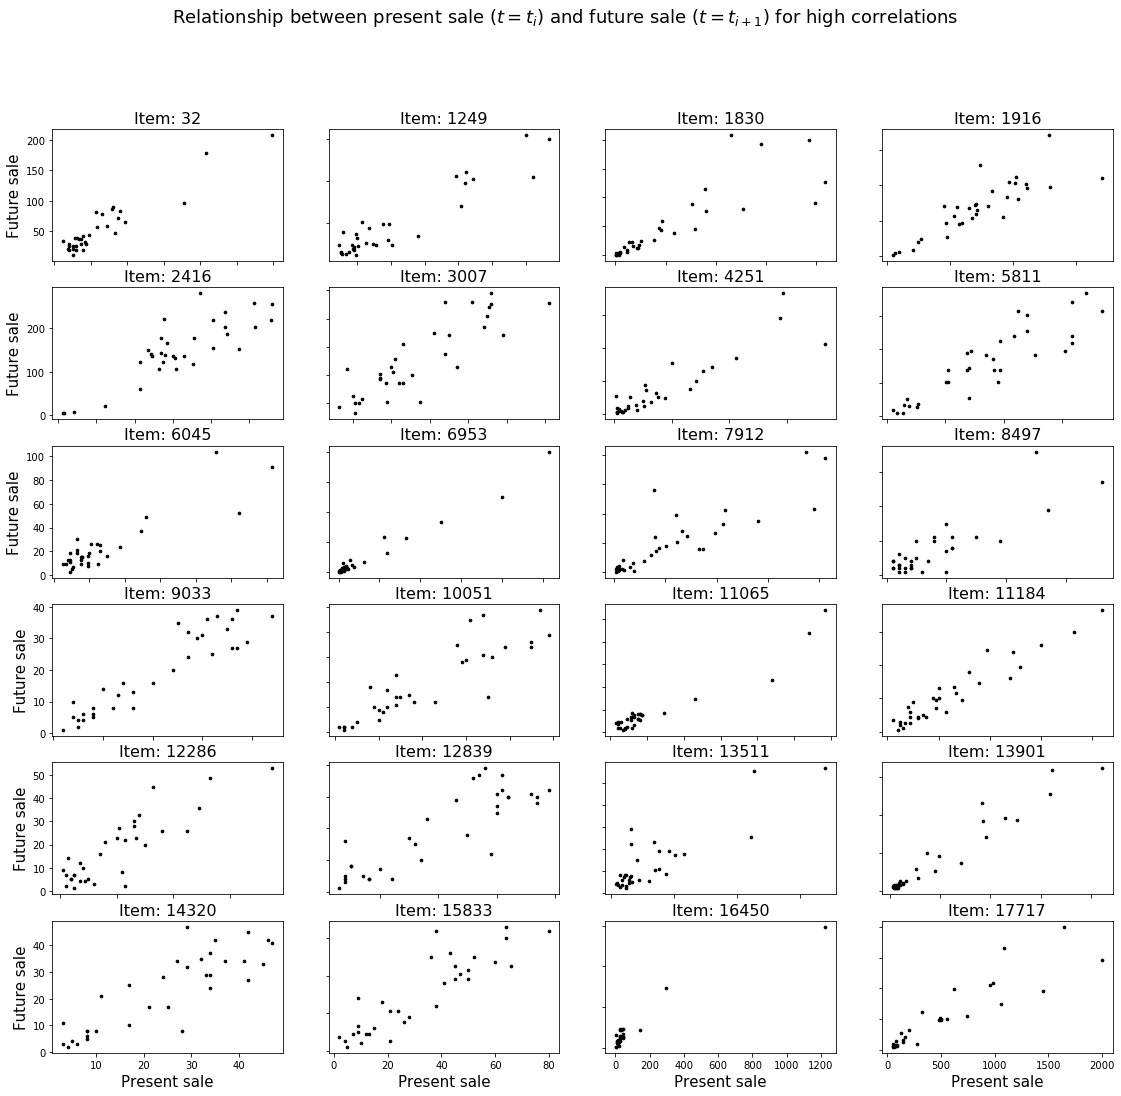

In [55]:
fig,ax = plt.subplots(6,4,figsize=(19,17))
k = 0

fig.suptitle('Relationship between present sale ($t = t_i$) and future sale ($t = t_{i+1}$) for high correlations',fontsize = 18)

for i in range(6):
    for j in range(4):
        sales_present = items_complete_series[items_high_corr][items_high_corr[k]][:-1]
        sales_future = random_rolled_series2[:-1,k]
        ax[i,j].scatter(sales_present, sales_future, s = 7,c='k')
        ax[i,j].set_title(f'Item: {items_high_corr[k]}',fontsize=16)
        k+=1
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Present sale',fontsize = 15)
    axx.set_ylabel('Future sale',fontsize = 15)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

### Method 1 for prediction: Sliding Window Method

The first time series prediction will be based on the correlation of the sale of a product at month $t_i$ vs the sale of the product at month $t_{i+1}$. A linear regression model will be applied and calculate the sale of some items in the 35th month.

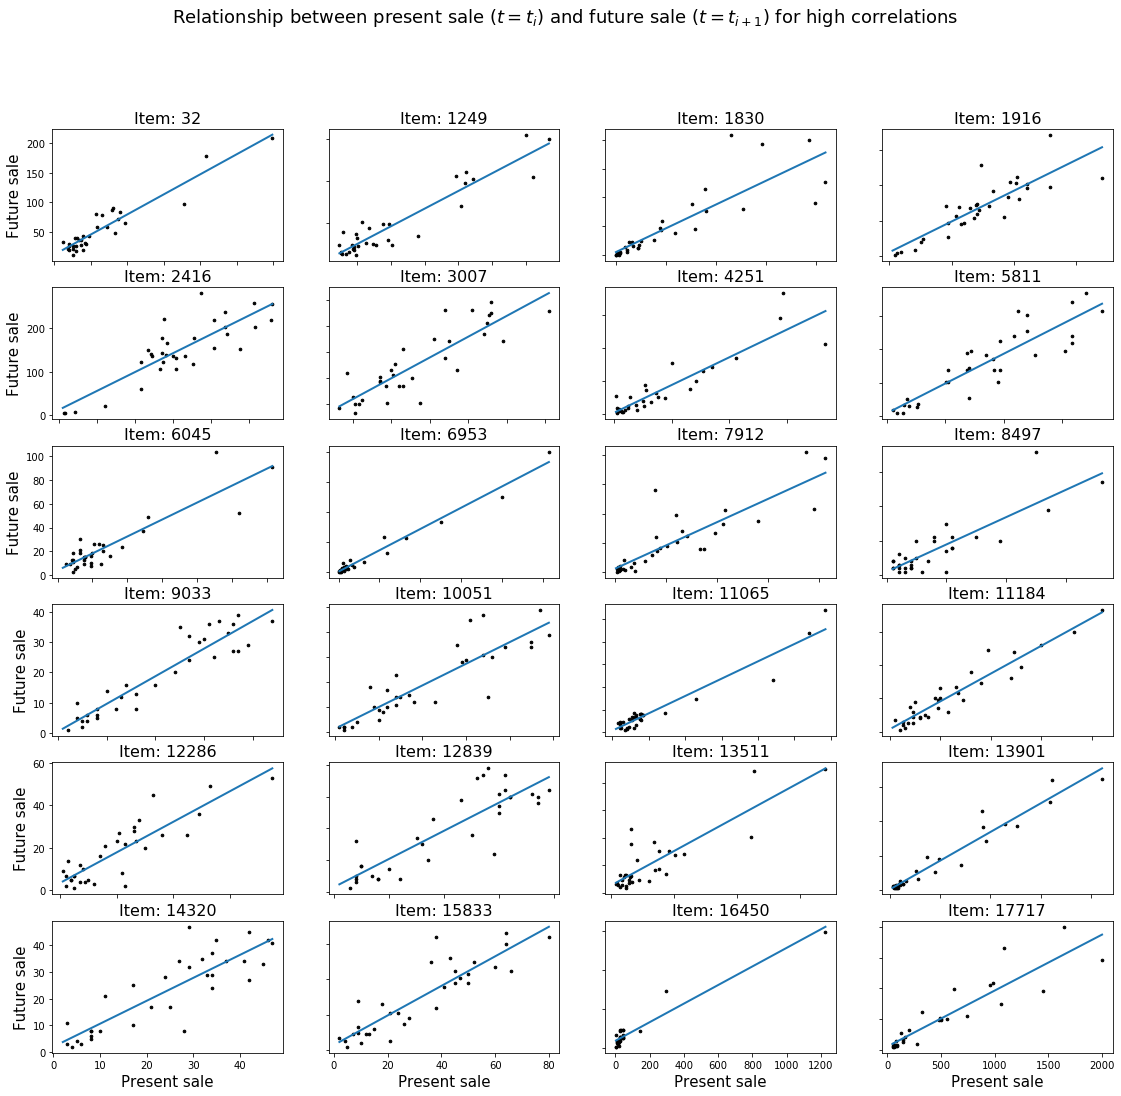

In [56]:
fig,ax = plt.subplots(6,4,figsize=(19,17))
k = 0

fig.suptitle('Relationship between present sale ($t = t_i$) and future sale ($t = t_{i+1}$) for high correlations',fontsize = 18)

for i in range(6):
    for j in range(4):
        sales_present = items_complete_series[items_high_corr][items_high_corr[k]][:-1]
        X = np.array(sales_present).reshape(-1,1)
        y = random_rolled_series2[:-1,k]
        
        reg = LinearRegression()
        reg.fit(X, y)
    
        X_pred = np.sort(np.array(items_complete_series[items_high_corr][items_high_corr[k]]))
        X_pred_reshape = X_pred.reshape(-1,1)
        y_pred = reg.predict(X_pred_reshape)
        
        ax[i,j].scatter(sales_present, y, s = 7,c='k')
        ax[i,j].plot(X_pred, y_pred, linewidth = 2)
        ax[i,j].set_title(f'Item: {items_high_corr[k]}',fontsize=16)
        
        k+=1
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Present sale',fontsize = 15)
    axx.set_ylabel('Future sale',fontsize = 15)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

In [57]:
months_pred = np.insert(months,len(months),34)

In [58]:
sales_present.shape

(33,)

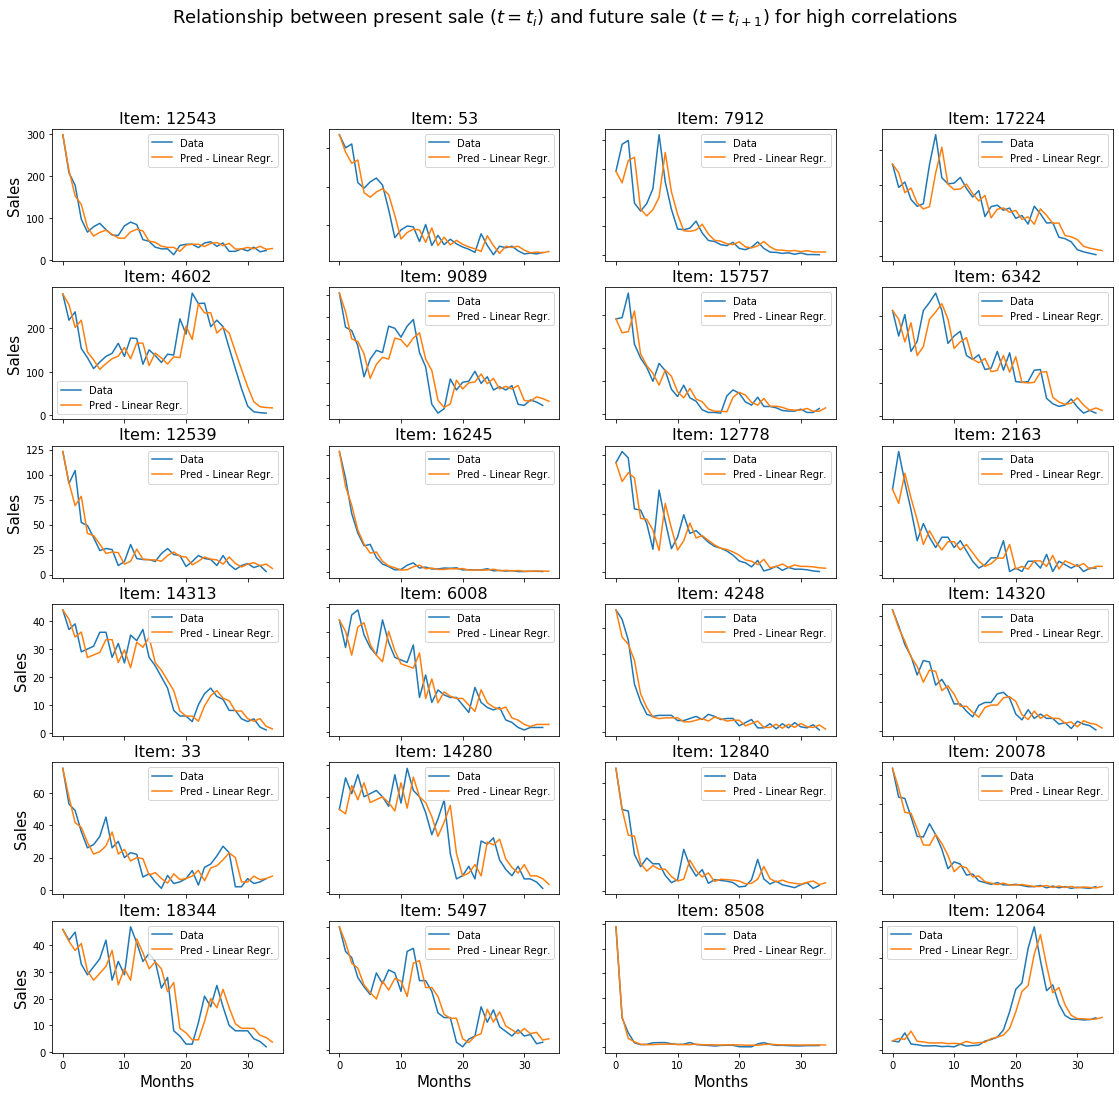

In [59]:
fig,ax = plt.subplots(6,4,figsize=(19,17))
k = 0

fig.suptitle('Relationship between present sale ($t = t_i$) and future sale ($t = t_{i+1}$) for high correlations',fontsize = 18)

for i in range(6):
    for j in range(4):
        sales_present = items_complete_series[items_high_corr][items_high_corr[k]][:-1]
        X = np.array(sales_present).reshape(-1,1)
        y = random_rolled_series2[:-1,k]
        
        reg = LinearRegression()
        reg.fit(X, y)
    
        X_pred = np.array(items_complete_series[items_high_corr][items_high_corr[k]])
        X_pred_reshape = X_pred.reshape(-1,1)
        y_pred = reg.predict(X_pred_reshape)
        y_pred = np.insert(y_pred, 0, sales_present[0])
        
        ax[i,j].plot(months, X_pred,label='Data')
        ax[i,j].plot(months_pred,y_pred,label = 'Pred - Linear Regr.')
        ax[i,j].set_title(f'Item: {random_items[k]}',fontsize=16)
        
        k+=1
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Months',fontsize = 15)
    axx.set_ylabel('Sales',fontsize = 15)
    axx.legend()
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

In [60]:
items_per_month = items_sales_df.groupby(['item_id'])['date_block_num'].count() # number of months that each item was sold
items_per_month_df = pd.DataFrame({'Num_Month':items_per_month}).reset_index() 
items_per_month_df

,item_id,Num_Month
0,0,1
1,1,5
2,2,2
3,3,2
4,4,1
...,...,...
21799,22165,2
21800,22166,25
21801,22167,26
21802,22168,4
